Описание проекта
Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика: 
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

In [1]:
!pip install lightgbm
!pip install catboost
!pip install shap
!pip install skorch
!pip install ydata_profiling
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import psycopg2
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, cross_validate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from skorch.classifier import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring, EarlyStopping
import shap
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, precision_recall_curve, PrecisionRecallDisplay
from skorch.callbacks import EarlyStopping, EpochScoring
from optuna.integration import OptunaSearchCV

RANDOM_SEED = 45

## Подключитесь к базе. Загрузите таблицы sql

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE';
'''

tables = pd.read_sql_query(query, con=engine) 

In [6]:
tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles
4,pg_foreign_table
...,...
63,sql_implementation_info
64,sql_languages
65,sql_packages
66,sql_sizing


In [7]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

case_ids = pd.read_sql_query(query, con=engine) 

In [8]:
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [9]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

vehicles = pd.read_sql_query(query, con=engine) 

In [10]:
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [11]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

collisions = pd.read_sql_query(query, con=engine) 

In [12]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [13]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

parties = pd.read_sql_query(query, con=engine) 

In [14]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


#### Предварительный вывод №1

Для анализа представлен комплекс из 3 таблиц, связанных общим ключом. 
Таблица 'collisions' — общая информация о ДТП:
Имеет уникальный case_id, который является уникальным идентификатором для каждого зарегистрированного происшествия;
Содержит общую информацию о происшествии, включая место, дату и время его происхождения, погодные условия, серьезность происшествия и другие характеристики.
Таблица 'parties' — информация об участниках ДТП:
Имеет case_id, который связан с соответствующим ДТП в таблице 'collisions'.
Для создания уникального идентификатора участника можно использовать комбинацию case_id и party_number.
Таблица 'vehicles' — информация о пострадавших машинах:
Содержит case_id и party_number, которые связаны с таблицами 'collisions' и 'parties'.
Данная таблица содержит информацию о пострадавших машинах, и каждая строка описывает одно транспортное средство.
Для создания уникального идентификатора машины можно использовать комбинацию case_id и party_number

Данные соответствуют условию задачи. 

## Проведите первичное исследование таблиц

In [15]:
query = '''
SELECT min(COLLISION_DATE),
       max(COLLISION_DATE)
FROM collisions
;
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,min,max
0,2009-01-01,2020-07-26


##  Проведите статистический анализ факторов ДТП

In [16]:
query = '''
SELECT CAST(EXTRACT(MONTH FROM COLLISION_DATE) AS INTEGER) AS month_num,
       COUNT(*) AS collision_count
FROM collisions
WHERE EXTRACT(YEAR FROM COLLISION_DATE)<2012
GROUP BY month_num
ORDER BY collision_count DESC;
'''
df = pd.read_sql_query(query, con=engine) 
display(df)

,month_num,collision_count
0,10,111933
1,12,107745
2,3,107036
3,5,105148
4,9,104649
5,11,104517
6,8,103467
7,7,101835
8,4,101032
9,1,99880


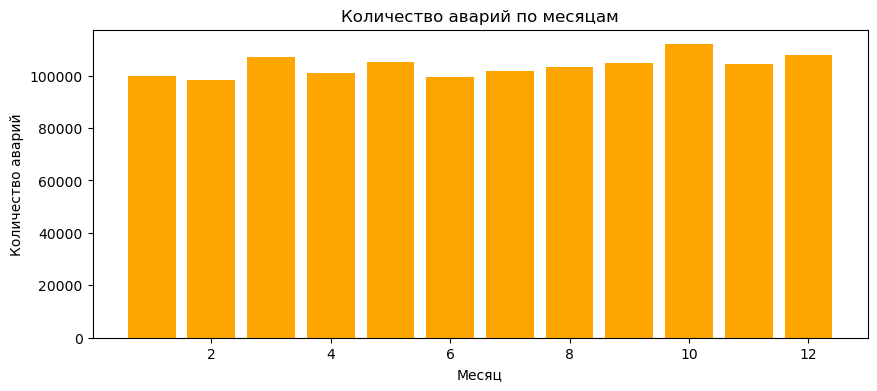

In [17]:
plt.figure(figsize=(10, 4))
plt.bar(df['month_num'], df['collision_count'], color='orange')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по месяцам')
plt.show()

#### Предварительный вывод №2

Представлены данные по дорожным проишествиям с 2009 по 2011 год. Сезонности в количестве аварий нет, максимальное число - в октябре, декабре и марте; минимальное - февраль, июнь, январь.

### Аналитические задачи

#### 1) Причины ДТП

In [18]:
query = '''
SELECT PCF_VIOLATION_CATEGORY, 
       COUNT(*) AS collision_count
FROM collisions
WHERE EXTRACT(YEAR FROM COLLISION_DATE)<2020
GROUP BY PCF_VIOLATION_CATEGORY
ORDER BY collision_count DESC
LIMIT 15;
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,pcf_violation_category,collision_count
0,speeding,438437
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


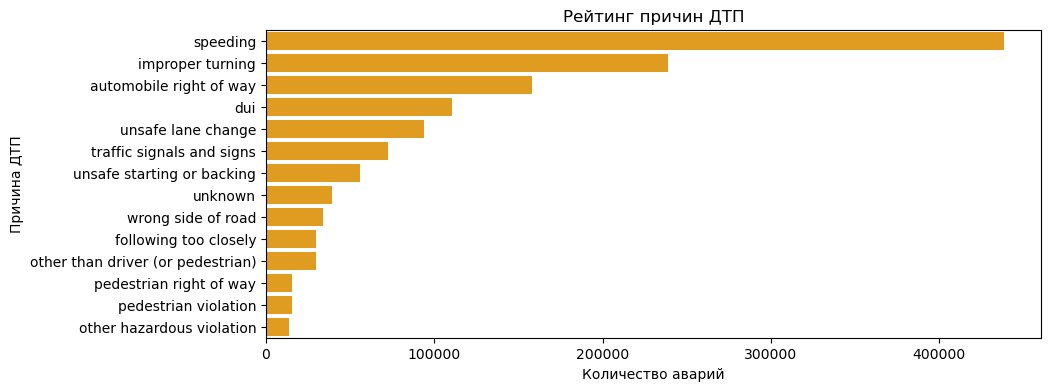

In [19]:
plt.figure(figsize=(10, 4))
sns.barplot(x='collision_count', y='pcf_violation_category', data=df, color='orange')
plt.xlabel('Количество аварий')
plt.ylabel('Причина ДТП')
plt.title('Рейтинг причин ДТП')
plt.show()


Самой частой причиной аварии является превышение скорости, на 2 и 3 местах - неправильный разворот и нарушение приоритета проезда.

#### 2) Анализ частоты ДТП в зависимости от состояния дороги и времени суток

In [20]:
query = '''
SELECT 
    CASE 
        WHEN EXTRACT(HOUR FROM collision_time) >= 0 AND EXTRACT(HOUR FROM collision_time) < 6 THEN 'Ночь'
        WHEN EXTRACT(HOUR FROM collision_time) >= 6 AND EXTRACT(HOUR FROM collision_time) < 12 THEN 'Утро'
        WHEN EXTRACT(HOUR FROM collision_time) >= 12 AND EXTRACT(HOUR FROM collision_time) < 18 THEN 'День'
        WHEN EXTRACT(HOUR FROM collision_time) >= 18 AND EXTRACT(HOUR FROM collision_time) < 24 THEN 'Вечер'
    END AS time_of_day,
    road_surface,
    COUNT(*) AS collision_count
FROM collisions 
WHERE road_surface IS NOT NULL AND 
      collision_time IS NOT NULL AND
      EXTRACT(YEAR FROM COLLISION_DATE)<2020
GROUP BY time_of_day, road_surface
ORDER BY time_of_day, collision_count DESC;
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,time_of_day,road_surface,collision_count
0,Вечер,dry,282305
1,Вечер,wet,30237
2,Вечер,snowy,1331
3,Вечер,slippery,263
4,День,dry,515649
5,День,wet,45640
6,День,snowy,2176
7,День,slippery,457
8,Ночь,dry,115261
9,Ночь,wet,17640


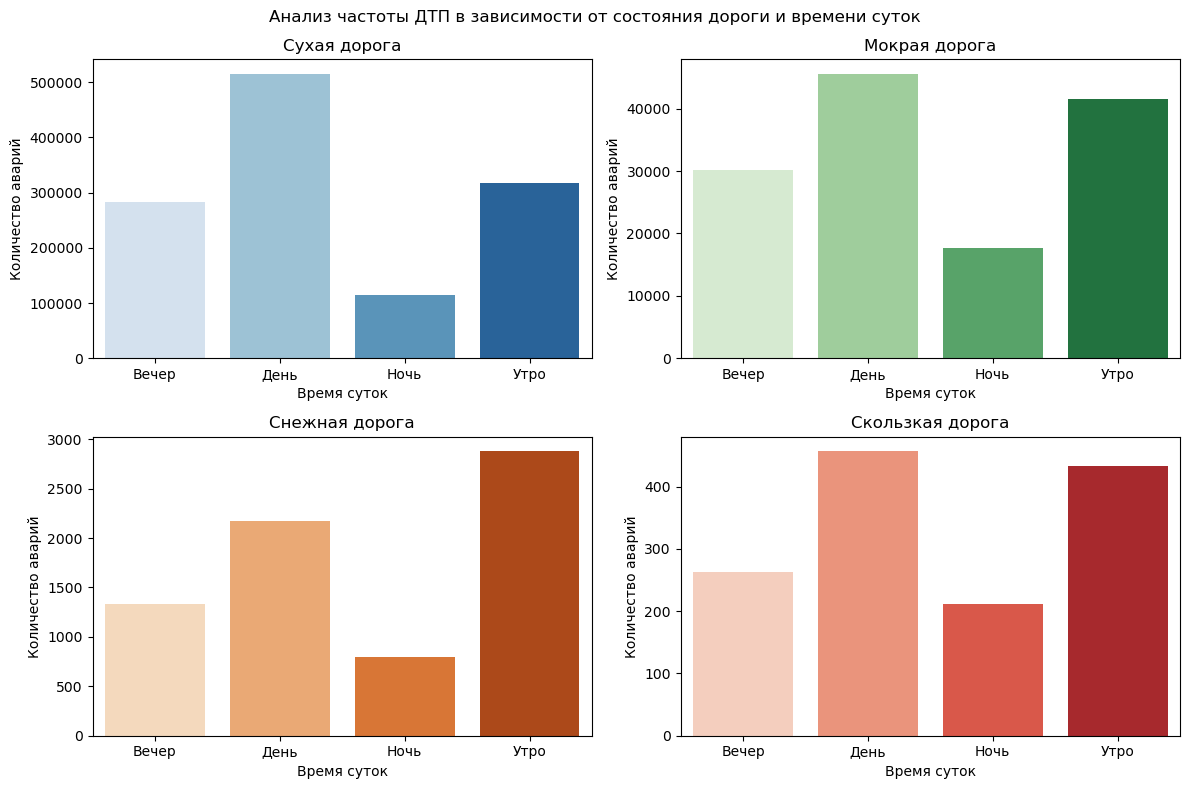

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Анализ частоты ДТП в зависимости от состояния дороги и времени суток')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'dry'],
            ax=axes[0, 0],
            palette='Blues')
axes[0, 0].set_title('Сухая дорога')
axes[0, 0].set_xlabel('Время суток')
axes[0, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'wet'],
            ax=axes[0, 1],
            palette='Greens')
axes[0, 1].set_title('Мокрая дорога')
axes[0, 1].set_xlabel('Время суток')
axes[0, 1].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'snowy'], 
            ax=axes[1, 0], 
            palette='Oranges')
axes[1, 0].set_title('Снежная дорога')
axes[1, 0].set_xlabel('Время суток')
axes[1, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'slippery'], 
            ax=axes[1, 1], 
            palette='Reds')
axes[1, 1].set_title('Скользкая дорога')
axes[1, 1].set_xlabel('Время суток')
axes[1, 1].set_ylabel('Количество аварий')

plt.tight_layout()
plt.show()

На графиках видно увеличения доли утренних проишествий в тех случаях, когда дорога не идеальна, особенно если она заснежена. 

#### 3) Анализ влияния уровня освещения на вероятность возникновения ДТП.

Сравнить количество ДТП в зависимости от уровня освещения (LIGHTING). Определить, в какое время суток и в каких условиях освещения ДТП происходят наиболее часто. Проанализировать, как уровень освещения влияет на вероятность возникновения ДТП. 

#### 4) Анализ зависимости вероятности возникновения ДТП от погодных условий.

Изучить влияние погодных условий (WEATHER_1) на вероятность возникновения ДТП. Сравнить количество ДТП в различных погодных условиях и определите, какие погодные условия сопровождаются наибольшим риском возникновения аварий.

#### 5) Анализ влияния уровня опьянения участников на тяжесть ДТП.

Исследовать связь между уровнем опьянения участников ДТП (PARTY_SOBRIETY) и серьезностью аварий (COLLISION_DAMAGE).
Выяснить, насколько опьянение участников влияет на тяжесть ДТП.

#### 6) Анализ влияния возраста автомобиля на тип аварий

In [22]:
query = '''
SELECT 
    CASE
        WHEN VEHICLE_AGE > 6 THEN 'Старые автомобили'
        ELSE 'Новые автомобили'
    END AS vehicle_category,
    TYPE_OF_COLLISION,
    COUNT(*) AS collision_count
FROM collisions c
     JOIN vehicles v ON c.CASE_ID = v.CASE_ID
WHERE VEHICLE_AGE IS NOT NULL AND
      TYPE_OF_COLLISION IS NOT NULL AND
      EXTRACT(YEAR FROM COLLISION_DATE)<2020
GROUP BY vehicle_category, TYPE_OF_COLLISION
ORDER BY vehicle_category, collision_count DESC;
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,vehicle_category,type_of_collision,collision_count
0,Новые автомобили,rear end,243754
1,Новые автомобили,broadside,164122
2,Новые автомобили,sideswipe,85965
3,Новые автомобили,hit object,79877
4,Новые автомобили,other,46581
5,Новые автомобили,head-on,35489
6,Новые автомобили,overturned,20717
7,Старые автомобили,rear end,118643
8,Старые автомобили,broadside,78713
9,Старые автомобили,sideswipe,37846


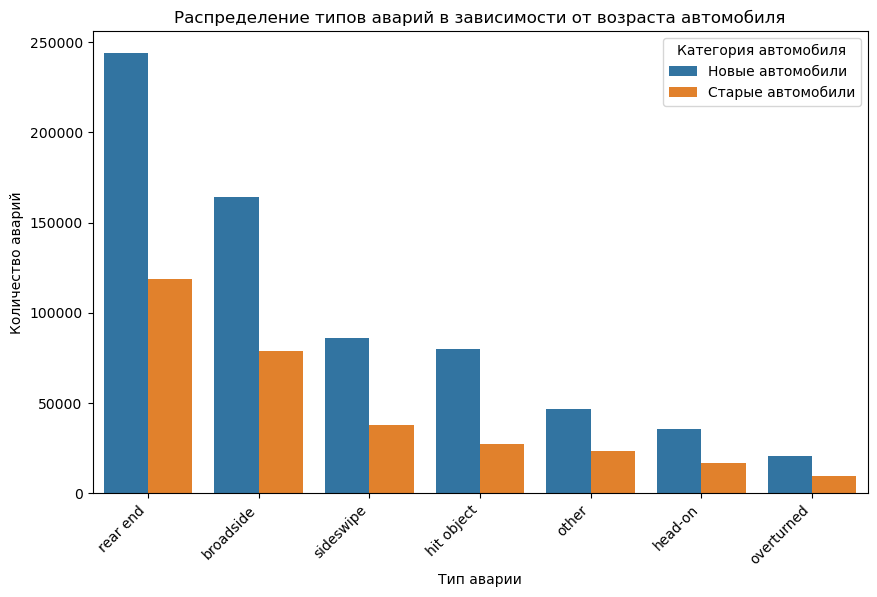

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='type_of_collision', y='collision_count', hue='vehicle_category', data=df)
plt.xlabel('Тип аварии')
plt.ylabel('Количество аварий')
plt.title('Распределение типов аварий в зависимости от возраста автомобиля')
plt.legend(title='Категория автомобиля', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

Значимых различий в частоте и спектре различных типов аварий у машин старше 6 лет и более новых не выявлено.

#### Предварительный вывод №3

Данные полученные из базы дорожных аварий, достаточно предсказуемы: растёт аварийность в периоды неблагоприятного климата (зима) и большая часть аварий связана с нарушением скоростного режима. Для решения большей части аналитических задач не хватает данных о поездках, прошедших без аварий. Без этих данных мы не можем судить об истинной частоте аварий. Нам доступно только оценивать относительное увеличение аварийности относительно базового уровни при идеальных условиях (солнце, сухая дорога и пр.) 

#### Выгрузка сводной таблицы для обучения моделей.

По условиям задания, модель должна предсказывать ДТП по вине пользователя каршеринга в момент начала аренды и формирования маршрута. Соответственно, в сводной таблице остаются только признаки известные на этот момент.

In [24]:
query = '''
SELECT 
       p.AT_FAULT,
       p.PARTY_DRUG_PHYSICAL,
       p.PARTY_SOBRIETY,
       v.VEHICLE_TYPE,
       v.VEHICLE_TRANSMISSION,
       v.VEHICLE_AGE,
       CASE 
        WHEN EXTRACT(HOUR FROM c.collision_time) >= 0 AND EXTRACT(HOUR FROM c.collision_time) < 6 THEN 'Ночь'
        WHEN EXTRACT(HOUR FROM c.collision_time) >= 6 AND EXTRACT(HOUR FROM c.collision_time) < 12 THEN 'Утро'
        WHEN EXTRACT(HOUR FROM c.collision_time) >= 12 AND EXTRACT(HOUR FROM c.collision_time) < 18 THEN 'День'
        WHEN EXTRACT(HOUR FROM c.collision_time) >= 18 AND EXTRACT(HOUR FROM c.collision_time) < 24 THEN 'Вечер'
    END AS time_of_day,
       c.WEATHER_1,
       c.ROAD_SURFACE,
       c.DIRECTION,
       c.LIGHTING,
       c.DISTANCE,
       c.LOCATION_TYPE,
       c.ROAD_CONDITION_1
FROM parties p INNER JOIN
     vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number LEFT JOIN
     collisions c ON p.case_id = c.case_id
WHERE p.case_id IN (SELECT case_id
                    FROM parties
                    WHERE PARTY_TYPE = 'car' AND
                          AT_FAULT = 1) AND
      c.COLLISION_DAMAGE NOT IN ('SCRATCH') AND
      EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;

'''
df_pr = pd.read_sql_query(query, con=engine) 
display(df_pr)

,at_fault,party_drug_physical,party_sobriety,vehicle_type,vehicle_transmission,vehicle_age,time_of_day,weather_1,road_surface,direction,lighting,distance,location_type,road_condition_1
0,1,None,had not been drinking,sedan,manual,2.0,День,clear,dry,north,daylight,47.0,None,normal
1,0,None,had not been drinking,sedan,manual,NaN,Вечер,clear,dry,None,dark with street lights,0.0,None,normal
2,1,None,had not been drinking,sedan,manual,4.0,День,clear,dry,east,dusk or dawn,30.0,None,normal
3,1,None,"had been drinking, under influence",sedan,auto,4.0,Ночь,clear,dry,south,dark with no street lights,1584.0,highway,normal
4,0,None,had not been drinking,sedan,manual,3.0,День,cloudy,dry,None,daylight,0.0,None,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102368,0,None,had not been drinking,coupe,manual,8.0,День,clear,dry,None,daylight,0.0,None,normal
102369,0,None,had not been drinking,coupe,manual,10.0,Вечер,clear,dry,south,dark with street lights,20.0,highway,normal
102370,0,None,had not been drinking,hatchback,manual,11.0,Вечер,clear,dry,south,dark with no street lights,3.0,None,normal
102371,0,None,had not been drinking,coupe,auto,3.0,День,clear,dry,None,daylight,0.0,None,normal


In [25]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102373 entries, 0 to 102372
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              102373 non-null  int64  
 1   party_drug_physical   4824 non-null    object 
 2   party_sobriety        100635 non-null  object 
 3   vehicle_type          102373 non-null  object 
 4   vehicle_transmission  100428 non-null  object 
 5   vehicle_age           99888 non-null   float64
 6   time_of_day           102257 non-null  object 
 7   weather_1             102108 non-null  object 
 8   road_surface          101618 non-null  object 
 9   direction             75055 non-null   object 
 10  lighting              102075 non-null  object 
 11  distance              102373 non-null  float64
 12  location_type         41781 non-null   object 
 13  road_condition_1      101860 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 10

In [26]:
df_pr.describe()

,at_fault,vehicle_age,distance
count,102373.000000,99888.000000,1.023730e+05
mean,0.450607,5.221818,6.753556e+02
std,0.497557,3.124829,5.521095e+03
min,0.000000,0.000000,0.000000e+00
25%,0.000000,3.000000,0.000000e+00
50%,0.000000,5.000000,1.000000e+02
75%,1.000000,7.000000,5.000000e+02
max,1.000000,161.000000,1.584000e+06


In [27]:
profile = ProfileReport(df_pr)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Анализ сформированного датасета показал, что целевой признак распределен равномерно. Есть высокая корреляция между возрастом автомобиля, употреблением алкоголя или нахождения под влиянием лекарств или наркотиков и виновностью в совершении ДТП. В сформированном датасете 7113 дубликатов (6.9%). Учитывая, что в датасете нет уникальной нумерации, вероятнее всего, это не истинные дубликаты, а участники ДТП с одинаковыми учётными признаками - дубликаты не удаляем.

In [28]:
df_pr = df_pr.dropna(subset=['vehicle_age'])
#удалены пропуски

In [29]:
df_pr['vehicle_age'].quantile(0.999)

14.0

In [30]:
df_pr.loc[df_pr['vehicle_age'] > 14, 'vehicle_age'] = df_pr['vehicle_age'].median()
#замена выброса (160 лет) на медианное значение

In [31]:
df_pr['vehicle_age'].describe()

count    99888.000000
mean         5.210516
std          3.032874
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         14.000000
Name: vehicle_age, dtype: float64

In [32]:
df_pr['distance'].quantile(0.95)

2640.0

In [33]:
df_pr.loc[df_pr['distance'] > 2640, 'distance'] = df_pr['distance'].median()
#замена выбросов (1584000) на медианное значение

In [34]:
df_pr['distance'].describe()

count    99888.000000
mean       321.256312
std        540.925774
min          0.000000
25%          0.000000
50%        100.000000
75%        379.000000
max       2640.000000
Name: distance, dtype: float64

In [35]:
df_pr['party_sobriety'] = df_pr['party_sobriety'].fillna('not_drinking')
#замена пропусков на самое частое значение


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
def replace_sobriety(x):
    if x in ['had not been drinking', 'impairment unknown', 'not applicable']: return 'not_drinking'
    elif x in ['had been drinking, not under influence', 'had been drinking, impairment unknown', 'had been drinking, under influence']: return 'drinking'
    

df_pr['party_sobriety'] = df_pr['party_sobriety'].apply(replace_sobriety)
#замена степеней опьянения на выбор: выпивал-не выпивал


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
df_pr['party_sobriety'].describe()

count            98200
unique               2
top       not_drinking
freq             91626
Name: party_sobriety, dtype: object

In [38]:
df_pr['party_drug_physical'] = df_pr['party_drug_physical'].fillna('not_drug')
#замена пропусков на самое частое значение


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
def replace_drug_physical(x):
    if x in ['under drug influence', 'sleepy/fatigued', 'impairment - physical']: return 'drug'
    else: return 'not_drug'
    
df_pr['party_drug_physical'] = df_pr['party_drug_physical'].apply(replace_drug_physical)
#замена степеней влияния лекарств или наркотиков на выбор: есть или нет


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
df_pr['party_drug_physical'].describe()

count        99888
unique           2
top       not_drug
freq         98102
Name: party_drug_physical, dtype: object

In [41]:
df_pr['weather_1'] = df_pr['weather_1'].fillna('clear')
#замена пропусков на самое частое значение


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
def replace_weather_1(x):
    if x in ['cloudy', 'raining', 'fog', 'snowing', 'other', 'wind']: return 'not_clear'
    else: return 'clear'
    
df_pr['weather_1'] = df_pr['weather_1'].apply(replace_weather_1)
#замена типов погоды на 2 значения


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
df_pr['weather_1'].describe()

count     99888
unique        2
top       clear
freq      80122
Name: weather_1, dtype: object

In [44]:
df_pr['road_surface'] = df_pr['road_surface'].fillna('dry')
#замена пропусков на самое частое значение


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
df_pr['lighting'] = df_pr['lighting'].fillna('daylight')
#замена пропусков на самое частое значение


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99888 entries, 0 to 102372
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              99888 non-null  int64  
 1   party_drug_physical   99888 non-null  object 
 2   party_sobriety        98200 non-null  object 
 3   vehicle_type          99888 non-null  object 
 4   vehicle_transmission  98391 non-null  object 
 5   vehicle_age           99888 non-null  float64
 6   time_of_day           99777 non-null  object 
 7   weather_1             99888 non-null  object 
 8   road_surface          99888 non-null  object 
 9   direction             73411 non-null  object 
 10  lighting              99888 non-null  object 
 11  distance              99888 non-null  float64
 12  location_type         41245 non-null  object 
 13  road_condition_1      99392 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.4+ MB


In [47]:
df_pr = df_pr.drop(['direction', 'location_type'], axis=1)
# удаление признаков не имеющих корелляции с целевым

In [48]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99888 entries, 0 to 102372
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              99888 non-null  int64  
 1   party_drug_physical   99888 non-null  object 
 2   party_sobriety        98200 non-null  object 
 3   vehicle_type          99888 non-null  object 
 4   vehicle_transmission  98391 non-null  object 
 5   vehicle_age           99888 non-null  float64
 6   time_of_day           99777 non-null  object 
 7   weather_1             99888 non-null  object 
 8   road_surface          99888 non-null  object 
 9   lighting              99888 non-null  object 
 10  distance              99888 non-null  float64
 11  road_condition_1      99392 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.9+ MB


In [49]:
df_pr.duplicated().sum()

45551

In [50]:
df_pr = df_pr.drop_duplicates()

In [51]:
X_1 = df_pr.drop(['at_fault'], axis=1)
y_1 = df_pr['at_fault']

In [52]:
features_train, features_test, target_train, target_test = train_test_split(
X_1, y_1, test_size=0.25, random_state=RANDOM_SEED)

In [53]:
numeric = ['vehicle_age', 'distance']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [54]:
cols_to_encode = ['party_drug_physical', 'party_sobriety', 'vehicle_type', 'vehicle_transmission', 'time_of_day', 'weather_1', 'road_surface', 'lighting', 'road_condition_1']

In [55]:
ohe=OneHotEncoder(drop='first', handle_unknown='error')
ct = make_column_transformer((ohe, cols_to_encode), remainder='passthrough')
ct.fit(features_train)
features_train_ohe = ct.transform(features_train)
features_test_ohe = ct.transform(features_test)

In [56]:
features_train_ohe.shape

(40752, 31)

In [57]:
features_test_ohe.shape

(13585, 31)

#### Предварительный вывод №4

Сформирована итоговая таблица для обучения моделей. Проведён её анализ, обработка пропусков, категориальных признаков, удалены незначащие признаки. Выполнена стандартизация количественных показателей методом StandardScaler и кодирование категориальных методом OneHotEncoder. 

## Создайте модель для оценки водительского риска

Для дальнейшего обучения моделей и оценки их качества была выбрана метрика Fbeta с уклоном на полноту. Метрика Fbeta пытается сбалансировать значения полноты и точности, чтобы найти среднее гармоническое значение между этими двумя показателями. Исходя из бизнесзадачи представляется разумным соблюдать компромисс между полнотой и риском большого количества ложноположительных результатов (запугивание клиента с последующим его уходом) и точностью с большим количеством ложноотрицательных результатов (повышение ущерба от аварий).

In [58]:
clf_1 = RandomForestClassifier(random_state=RANDOM_SEED)
ftwo_scorer = make_scorer(fbeta_score, beta=2)
params_1 = {'criterion': ['gini', 'entropy'], 'n_estimators': range (10, 200, 10), 'max_depth': range(1, 12, 2)}
search_1 = GridSearchCV(clf_1, params_1, cv=5, n_jobs=-1, scoring=ftwo_scorer)
search_1.fit(features_train_ohe, target_train)
best_clf_1 = search_1.best_estimator_

In [59]:
best_clf_1

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=80,
                       random_state=45)

In [60]:
search_1.best_score_

0.5169175187860574

In [61]:
clf_2 = LogisticRegression(random_state=12345)

params_2 = {'max_iter': range (500, 5000, 500)}
search_2 = GridSearchCV(clf_2, params_2, cv=5, n_jobs=-1, scoring=ftwo_scorer)
search_2.fit(features_train_ohe, target_train)
best_clf_2 = search_2.best_estimator_

In [62]:
best_clf_2

LogisticRegression(max_iter=500, random_state=12345)

In [63]:
search_2.best_score_

0.4952144610250773

In [64]:
enc = OrdinalEncoder()
ct_2 = make_column_transformer((enc, cols_to_encode), remainder='passthrough')
ct_2.fit(features_train)
features_train_enc = ct_2.transform(features_train)
features_test_enc = ct_2.transform(features_test)
#При попытке использования внутреннего кодирования категориальных признаков как LGBMClassifier так и CatBoostClassifier код
#выдавал ошибку.

In [65]:
clf_3 = lgb.LGBMClassifier()
params_3 = {'n_estimators': range(100, 250, 50), 'max_depth': range(3, 13, 2), 'learning_rate': [0.01, 0.05, 0.1]}
search_3 = GridSearchCV(clf_3, params_3, cv=5, n_jobs=-1, scoring=ftwo_scorer)
search_3.fit(features_train_enc, target_train)
best_clf_3 = search_3.best_estimator_

In [66]:
best_clf_3

LGBMClassifier(max_depth=9, n_estimators=200)

In [67]:
search_3.best_score_

0.5562316300061727

In [68]:
clf_4 = CatBoostClassifier(loss_function='Logloss')
params_4 = {'iterations': [100, 500, 1000], 'depth': [4, 6, 8], 'learning_rate': [0.01, 0.05, 0.1]}
search_4 = GridSearchCV(clf_4, params_4, cv=5, n_jobs=-1, scoring=ftwo_scorer)
search_4.fit(features_train_enc, target_train)
best_clf_4 = search_4.best_estimator_

0:	learn: 0.6630849	total: 172ms	remaining: 1m 25s
1:	learn: 0.6409041	total: 214ms	remaining: 53.3s
2:	learn: 0.6322746	total: 252ms	remaining: 41.7s
3:	learn: 0.6199238	total: 285ms	remaining: 35.3s
4:	learn: 0.6141431	total: 316ms	remaining: 31.2s
5:	learn: 0.6061789	total: 346ms	remaining: 28.5s
6:	learn: 0.6028904	total: 378ms	remaining: 26.6s
7:	learn: 0.5983410	total: 421ms	remaining: 25.9s
8:	learn: 0.5961685	total: 470ms	remaining: 25.6s
9:	learn: 0.5941616	total: 499ms	remaining: 24.5s
10:	learn: 0.5927594	total: 533ms	remaining: 23.7s
11:	learn: 0.5913910	total: 560ms	remaining: 22.8s
12:	learn: 0.5904166	total: 595ms	remaining: 22.3s
13:	learn: 0.5893246	total: 637ms	remaining: 22.1s
14:	learn: 0.5886092	total: 678ms	remaining: 21.9s
15:	learn: 0.5877924	total: 719ms	remaining: 21.8s
16:	learn: 0.5869855	total: 757ms	remaining: 21.5s
17:	learn: 0.5863887	total: 795ms	remaining: 21.3s
18:	learn: 0.5859471	total: 829ms	remaining: 21s
19:	learn: 0.5840900	total: 871ms	remainin

168:	learn: 0.5638032	total: 6.04s	remaining: 11.8s
169:	learn: 0.5637197	total: 6.08s	remaining: 11.8s
170:	learn: 0.5636236	total: 6.11s	remaining: 11.8s
171:	learn: 0.5635412	total: 6.14s	remaining: 11.7s
172:	learn: 0.5634688	total: 6.17s	remaining: 11.7s
173:	learn: 0.5634144	total: 6.21s	remaining: 11.6s
174:	learn: 0.5633441	total: 6.23s	remaining: 11.6s
175:	learn: 0.5632599	total: 6.26s	remaining: 11.5s
176:	learn: 0.5631728	total: 6.3s	remaining: 11.5s
177:	learn: 0.5631265	total: 6.33s	remaining: 11.5s
178:	learn: 0.5630609	total: 6.36s	remaining: 11.4s
179:	learn: 0.5629546	total: 6.39s	remaining: 11.4s
180:	learn: 0.5628685	total: 6.42s	remaining: 11.3s
181:	learn: 0.5627662	total: 6.44s	remaining: 11.3s
182:	learn: 0.5627274	total: 6.47s	remaining: 11.2s
183:	learn: 0.5626334	total: 6.5s	remaining: 11.2s
184:	learn: 0.5625814	total: 6.55s	remaining: 11.2s
185:	learn: 0.5625243	total: 6.61s	remaining: 11.2s
186:	learn: 0.5624683	total: 6.64s	remaining: 11.1s
187:	learn: 0.

329:	learn: 0.5534687	total: 10.8s	remaining: 5.56s
330:	learn: 0.5533959	total: 10.8s	remaining: 5.53s
331:	learn: 0.5533443	total: 10.9s	remaining: 5.5s
332:	learn: 0.5532888	total: 10.9s	remaining: 5.46s
333:	learn: 0.5532241	total: 10.9s	remaining: 5.43s
334:	learn: 0.5531683	total: 10.9s	remaining: 5.39s
335:	learn: 0.5531118	total: 11s	remaining: 5.36s
336:	learn: 0.5530529	total: 11s	remaining: 5.33s
337:	learn: 0.5529878	total: 11.1s	remaining: 5.3s
338:	learn: 0.5529064	total: 11.1s	remaining: 5.27s
339:	learn: 0.5528570	total: 11.1s	remaining: 5.23s
340:	learn: 0.5527944	total: 11.1s	remaining: 5.2s
341:	learn: 0.5527392	total: 11.2s	remaining: 5.16s
342:	learn: 0.5527014	total: 11.2s	remaining: 5.13s
343:	learn: 0.5526449	total: 11.2s	remaining: 5.1s
344:	learn: 0.5526043	total: 11.3s	remaining: 5.07s
345:	learn: 0.5525475	total: 11.3s	remaining: 5.03s
346:	learn: 0.5524915	total: 11.3s	remaining: 5s
347:	learn: 0.5524493	total: 11.4s	remaining: 4.97s
348:	learn: 0.5524055	t

491:	learn: 0.5450945	total: 16.1s	remaining: 261ms
492:	learn: 0.5450610	total: 16.1s	remaining: 229ms
493:	learn: 0.5450037	total: 16.1s	remaining: 196ms
494:	learn: 0.5449495	total: 16.2s	remaining: 163ms
495:	learn: 0.5448865	total: 16.2s	remaining: 131ms
496:	learn: 0.5448415	total: 16.2s	remaining: 97.9ms
497:	learn: 0.5447845	total: 16.2s	remaining: 65.2ms
498:	learn: 0.5447144	total: 16.3s	remaining: 32.6ms
499:	learn: 0.5446904	total: 16.3s	remaining: 0us


In [69]:
best_clf_4

In [70]:
search_4.best_score_

0.5549158117818875

In [71]:
X_train_array = features_train_ohe.toarray()
X_test_array = features_test_ohe.toarray()


X_train_tensor = torch.from_numpy(X_train_array).to(torch.float32)
X_test_tensor = torch.from_numpy(X_test_array).to(torch.float32)
y_train_tensor = torch.Tensor(target_train.values)
y_test_tensor = torch.Tensor(target_test.values)


for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape} - {globals()[x].dtype}')

Размерность X_train_tensor: torch.Size([40752, 31]) - torch.float32
Размерность X_test_tensor: torch.Size([13585, 31]) - torch.float32
Размерность y_train_tensor: torch.Size([40752]) - torch.float32
Размерность y_test_tensor: torch.Size([13585]) - torch.float32


In [72]:
class Batch(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]
    data = self.data[idx]
    sample = {'data': data, 'at_fault': label}
    return sample

In [73]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_test_tensor, y_test_tensor)

In [74]:
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

In [75]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss 
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

In [76]:
input_size = X_train_tensor.shape[1]  
hidden_size_1 = 50  
hidden_size_2 = 40  
hidden_size_3 = 5  
hidden_size_4 = 45  
output_size = 1 
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.ReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.001  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 200  # размер пакета

In [77]:
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.Mean Squared Error()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [78]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    result = {'train_loss': [], 'test_loss': [], 'fbeta': [],
              'best_epoch': None, 'stopping_epoch': None, 'best_model': None}

    early_stopping = CustomEarlyStopping(patience, min_delta)

    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss_train = 0.0

        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['at_fault']
            label_train = label_train.unsqueeze(1)

            optimizer.zero_grad()

            predictions = model(data)
            loss_value = loss(predictions, label_train.float())  
            total_loss_train += loss_value.item()

            loss_value.backward()
            optimizer.step()

        train_loss = total_loss_train / len(train_dataloader)
        result['train_loss'].append(train_loss)

        # тестирование
        model.eval()
        total_loss_test = 0.0
        total_fbeta_test = 0.0  
        
        with torch.no_grad():  # отключение вычисления градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['at_fault']
                label_test = label_test.unsqueeze(1)

                predictions = model(data)
                loss_value = loss(predictions, label_test.float())
                total_loss_test += loss_value.item()
                
                binary_predictions = (predictions >= 0.5).int()
                total_fbeta_test += fbeta_score(label_test, binary_predictions, beta=2)
                
        test_loss = total_loss_test / len(test_dataloader)
        result['test_loss'].append(test_loss)
        result['fbeta'].append(total_fbeta_test / len(test_dataloader))
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f'Epoch: {epoch} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Fbeta: {result["fbeta"][-1]:.2f}')

        early_stopping(test_loss)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch - patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch - patience} Train Loss: {result['train_loss'][-patience]:.4f} Test Loss: {result['test_loss'][-patience]:.4f}")
            print(f"Fbeta: {result['fbeta'][-patience]:.2f} ")
            break
        if epoch == n_epochs - 1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} Train Loss: {result['train_loss'][-1]:.4f} Test Loss: {result['test_loss'][-1]:.4f}")
            print(f"Fbeta: {result['fbeta'][-1]:.2f}")

    return result

result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 Train Loss: 0.6706 Test Loss: 0.6349 Fbeta: 0.36
Epoch: 10 Train Loss: 0.5804 Test Loss: 0.5837 Fbeta: 0.32
Epoch: 20 Train Loss: 0.5778 Test Loss: 0.5824 Fbeta: 0.33
Epoch: 30 Train Loss: 0.5761 Test Loss: 0.5821 Fbeta: 0.35
Epoch: 40 Train Loss: 0.5754 Test Loss: 0.5822 Fbeta: 0.34
Epoch: 50 Train Loss: 0.5735 Test Loss: 0.5831 Fbeta: 0.34
Epoch: 60 Train Loss: 0.5729 Test Loss: 0.5821 Fbeta: 0.36
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 41 Train Loss: 0.5744 Test Loss: 0.5830
Fbeta: 0.36 


Подбор параметров нейросети пакетом Optuna не пошёл с использованием make_scorer. Как результат взял результат базовой нейросети.

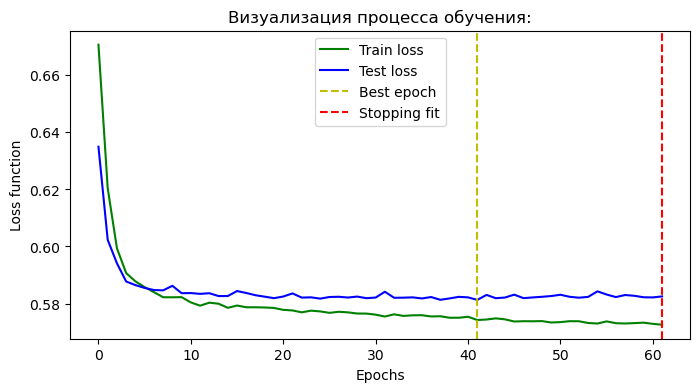

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(result['train_loss'], color='green', label='Train loss')
plt.plot(result['test_loss'], color='blue', label='Test loss')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()


In [80]:
data = {
    'Metrics': ['Fbeta'],
    'RandomForestClassifier': [round(search_1.best_score_, 4 )],
    'LogisticRegression': [round(search_2.best_score_, 4)],
    'LGBMClassifier': [round(search_3.best_score_, 4)],
    'CatBoostClassifier': [round(search_4.best_score_, 4)],
    'NeuralNetClassifier': 0.34
}
display(pd.DataFrame(data))

,Metrics,RandomForestClassifier,LogisticRegression,LGBMClassifier,CatBoostClassifier,NeuralNetClassifier
0,Fbeta,0.5169,0.4952,0.5562,0.5549,0.34


#### Предварительный вывод №5

Были подобраны параметры и обучены 5 моделей: RandomForestClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier и NeuralNetClassifier. Ожидаемо с задачей бинарной классификации хуже всех справилась нейронная сеть с 4 скрытыми слоями (метрика Fbeta = 0.29), лучший результат показал CatBoostClassifier с метрикой F1 = 0.4998

In [81]:
pred = best_clf_4.predict(features_test_enc)
    
Fbeta = fbeta_score(target_test, pred, beta=2)

# вывод результатов
print(f'Метрика CatBoost на тестовых данных: Fbeta:', round(Fbeta, 4))

Метрика CatBoost на тестовых данных: Fbeta: 0.5478


In [82]:
cm = confusion_matrix(target_test, pred)

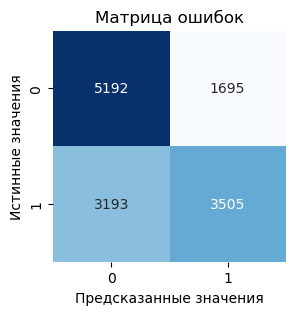

In [83]:
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")
plt.show()

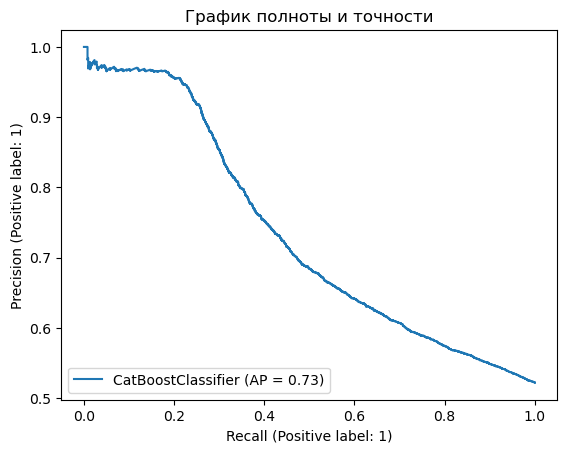

In [84]:
display = PrecisionRecallDisplay.from_estimator(
    best_clf_4, features_test_enc, target_test, name="CatBoostClassifier")
_ = display.ax_.set_title("График полноты и точности")

## Проведите анализ важности факторов ДТП

In [85]:
feature_importances = best_clf_4.get_feature_importance()

# создаем DataFrame с feature importances
df_feature_importances = pd.DataFrame({'Feature': pd.DataFrame(features_test_enc).columns, 'Importance': feature_importances})

# сортируем по убыванию значений Importance
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

# выводим таблицей feature importances
print(df_feature_importances)


    Feature  Importance
2         2   66.292727
1         1   10.402323
10       10    5.387913
9         9    5.163000
0         0    4.600897
4         4    1.867876
7         7    1.736926
8         8    1.351724
3         3    1.291341
6         6    1.253457
5         5    0.651816


In [86]:
features_test

,party_drug_physical,party_sobriety,vehicle_type,vehicle_transmission,vehicle_age,time_of_day,weather_1,road_surface,lighting,distance,road_condition_1
79670,not_drug,not_drinking,sedan,manual,1.157733,День,not_clear,dry,daylight,0.193993,normal
86807,not_drug,not_drinking,coupe,auto,1.478912,Ночь,clear,dry,dark with street lights,0.724402,normal
21960,not_drug,not_drinking,coupe,auto,1.157733,Утро,clear,dry,dusk or dawn,-0.715279,normal
78313,not_drug,not_drinking,coupe,auto,2.442450,Вечер,clear,dry,dark with no street lights,-0.715279,normal
76388,not_drug,not_drinking,sedan,auto,-0.448163,День,not_clear,dry,daylight,-0.580955,normal
...,...,...,...,...,...,...,...,...,...,...,...
89458,not_drug,not_drinking,coupe,manual,-0.126984,Вечер,clear,dry,dark with no street lights,1.103266,construction
9027,not_drug,not_drinking,sedan,auto,-1.411701,Вечер,clear,dry,dark with street lights,-0.336416,normal
24582,not_drug,not_drinking,sedan,auto,1.157733,Вечер,clear,dry,dark with street lights,1.867881,normal
96944,not_drug,not_drinking,sedan,auto,1.800092,Вечер,not_clear,wet,dark with street lights,-0.543069,normal


In [87]:
pd.DataFrame(features_test_enc)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,1.0,4.0,1.0,1.0,1.0,0.0,3.0,4.0,1.157733,0.193993
1,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,4.0,1.478912,0.724402
2,1.0,1.0,0.0,0.0,3.0,0.0,0.0,4.0,4.0,1.157733,-0.715279
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.442450,-0.715279
4,1.0,1.0,4.0,0.0,1.0,1.0,0.0,3.0,4.0,-0.448163,-0.580955
...,...,...,...,...,...,...,...,...,...,...,...
13580,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.126984,1.103266
13581,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,-1.411701,-0.336416
13582,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,1.157733,1.867881
13583,1.0,1.0,4.0,0.0,0.0,1.0,3.0,1.0,4.0,1.800092,-0.543069


#### Предварительный вывод №6

При оценке важности признаков есть некоторое затруднение в интерпретации данных, вероятнее всего, самые важные признаки для прогнозирования ДТП это party_drug_physical и party_sobriety (употребление наркотиков или алкоголя). Для выявления алкогольного или наркотического опьянения можно перед запуском двигателя проводить простой тест для оценки когнитивных функций (например, повтор 5 слов в определённом порядке).

## Выводы

В ходе анализа и построения моделей для предсказания столкновений на дороге и определения виновников ДТП, были рассмотрены пять различных моделей: RandomForestClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, NeuralNetClassifier. Каждая из этих моделей основана на различных алгоритмах машинного обучения.

Лучшей моделью для предсказания виновников ДТП оказалась модель CatBoost. Она продемонстрировала наибольшую точность предсказания среди всех рассмотренных моделей, а именно:
Fbeta: 0.5014 на тестовой выборке. 

При оценке вклада разных факторов в вероятность возникновения ДТП самое большое влияние оказывает алкогольное или наркотическое 
опьянение. С учётом разнообразия веществ вызывающих опьянение, больших затрат на установку алкотестеров (не выявляющих наркотическое опьянение), представляется разумным перед запуском двигателя проводить простой тест для оценки когнитивных функций (например, повтор 5 слов в определённом порядке).
